# MC simulations using R feature selection 


In [1]:
import os
from sys import stdout

import time

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peakutils
%matplotlib inline 
from math import sqrt
from scipy.signal import savgol_filter
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
import scipy.io
from sklearn import model_selection
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.linear_model import ElasticNet,ElasticNetCV
from sklearn.svm import SVR
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.model_selection import learning_curve

from deap import base
from deap import creator
from deap import tools

from feature_selection import *
from utils import *


import warnings
warnings.filterwarnings('ignore')

# Data loading

In [2]:
#x_df = pd.read_csv('./al_basic.csv', sep = ',')
#x_df = pd.read_csv('./al_norm.csv', sep = ',')
#x_df = pd.read_csv('./al_snv.csv', sep = ',')
#x_df = pd.read_csv('./al_sum.csv', sep = ',')
#x_df = pd.read_csv('./al_max.csv', sep = ',')

#x_df = pd.read_csv('./al_noBaseline_basic.csv', sep = ',')
#x_df = pd.read_csv('./al_noBaseline_snv.csv', sep = ',')
#x_df = pd.read_csv('./al_noBaseline_sum.csv', sep = ',')

#x_df = pd.read_csv('./avg_dark_basic.csv', sep = ',')
x_df = pd.read_csv('./avg_dark_snv.csv', sep = ',')
#x_df = pd.read_csv('./avg_dark_sum.csv', sep = ',')

values = x_df.values
#wl=x_df.columns.values
#print(wl.shape)

print(values.shape)
print(values[1].shape)
print(len(values))
x_df

(27, 4094)
(4094,)
27


,188.195100,188.260100,188.325000,188.390000,188.455000,188.520000,188.585000,188.650000,188.714900,188.779900,...,440.300000,440.353000,440.406100,440.459200,440.512300,440.565300,440.618400,440.671400,440.724500,440.777500
0,-0.202300,-0.204963,-0.199886,-0.206818,-0.198427,-0.187784,-0.171972,-0.163457,-0.163944,-0.184738,...,-0.069106,-0.076430,-0.083934,-0.083035,-0.061017,-0.076543,-0.085366,-0.082994,-0.097306,-0.082470
1,-0.216713,-0.219512,-0.214245,-0.223380,-0.213660,-0.202860,-0.185480,-0.178051,-0.178859,-0.200712,...,-0.086271,-0.084517,-0.087155,-0.078665,-0.056357,-0.081120,-0.096511,-0.097939,-0.113908,-0.099779
2,-0.190769,-0.194015,-0.189509,-0.194752,-0.188089,-0.178043,-0.164843,-0.157486,-0.157699,-0.175545,...,-0.054121,-0.045138,-0.040921,-0.024425,0.000624,-0.028127,-0.042511,-0.030380,-0.031838,-0.013194
3,-0.197436,-0.198420,-0.195883,-0.199145,-0.195537,-0.189682,-0.182572,-0.177442,-0.177983,-0.189635,...,-0.042622,-0.024934,-0.017934,0.006893,0.039598,-0.009110,-0.048876,-0.058543,-0.076555,-0.065215
4,-0.202865,-0.203220,-0.201648,-0.206595,-0.201121,-0.194806,-0.187243,-0.180730,-0.182450,-0.195478,...,-0.072091,-0.071267,-0.076365,-0.071155,-0.046481,-0.070313,-0.086464,-0.087556,-0.101689,-0.089393
5,-0.201501,-0.201602,-0.199317,-0.204425,-0.198113,-0.194891,-0.186483,-0.180977,-0.182246,-0.192851,...,-0.051321,-0.023643,-0.009669,0.022466,0.058920,0.000581,-0.043303,-0.049570,-0.062509,-0.047070
6,-0.179028,-0.178158,-0.176850,-0.180733,-0.176306,-0.171279,-0.165082,-0.159211,-0.160900,-0.170410,...,-0.052552,-0.054307,-0.060227,-0.054641,-0.032600,-0.052414,-0.066230,-0.066946,-0.080670,-0.069113
7,-0.167365,-0.167919,-0.165931,-0.168243,-0.165788,-0.161813,-0.155986,-0.150864,-0.152766,-0.160435,...,-0.046119,-0.046454,-0.049368,-0.043090,-0.023943,-0.042925,-0.057730,-0.059131,-0.070887,-0.062748
8,-0.197283,-0.198228,-0.195046,-0.199682,-0.195552,-0.189965,-0.182246,-0.177668,-0.178809,-0.189325,...,-0.073941,-0.077197,-0.082306,-0.077021,-0.055050,-0.070556,-0.080687,-0.075530,-0.084957,-0.068945
9,-0.170323,-0.171516,-0.170169,-0.172749,-0.169156,-0.163686,-0.156783,-0.151798,-0.152542,-0.163118,...,-0.043824,-0.049392,-0.056505,-0.054733,-0.034985,-0.048803,-0.057371,-0.055174,-0.065248,-0.054373


[[188.1951 188.2601 188.325  ... 440.6714 440.7245 440.7775]]
wl shape:  (4094, 1)


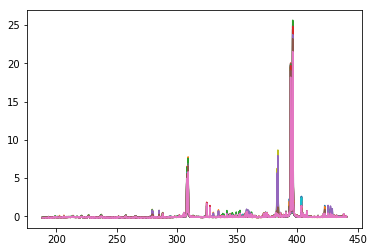

In [3]:
#This is just for visualizing the various plots of the samples
mat = scipy.io.loadmat("./data/002_29-Granges6958-v-335_200Hz_QS295_trig1435_int0.1.mat")
wl= mat["wl"]
print(wl.T)
print("wl shape: ", wl.shape)

for i in range(len(values)):
    plt.plot(wl, values[i])
    #plt.show()

In [4]:
print(wl[0])
print(wl[-1])

[188.1951]
[440.7775]


In [5]:
df_y = pd.read_csv('./al_concentration_final.csv')
print(type(df_y))
concentration=df_y.values
print(concentration.shape)
#print(concentration)

y_values=df_y.values
y_all=pd.DataFrame(y_values[:,2:10])
#print(y_all)
df_y

<class 'pandas.core.frame.DataFrame'>
(27, 14)


,Measurement,Reference material,Si,Fe,Mg,Ti,Ni,Zn,Cu,Mn,Pb,Sn,Cr,Al
0,1,Pech. 68451,0.070,0.100,0.4100,0.0400,0.0400,0.180,0.060,1.4500,0.0000,0.0000,0.0000,97.6
1,2,Gränges al 6958-v-335,0.180,0.350,2.0300,0.0600,0.0000,6.080,1.350,0.4500,0.0000,0.0000,0.1000,89.4
2,3,4343-AA,7.460,0.530,0.0360,0.0450,0.0310,0.140,0.150,0.1000,0.0000,0.0000,0.0000,91.4
3,10,Pech. 1206,3.000,0.795,0.5700,0.0930,0.3010,0.154,4.290,0.0370,0.1000,0.2000,0.0000,90.5
4,11,Gränges al 6958-v-331,0.120,0.300,3.0400,0.0290,0.0000,4.930,1.850,0.0600,0.0000,0.0000,0.4000,89.3
5,12,NIST 1255a,7.220,0.140,0.3600,0.1540,0.0180,0.084,0.120,0.0530,0.0000,0.0000,0.0000,91.8
6,14,NBS 1258,0.780,0.079,0.9800,0.0000,0.0010,1.030,0.840,0.4800,0.0000,0.0000,0.0000,95.8
7,15,O 2:3,6.160,0.000,0.3630,0.0080,0.0000,0.000,0.006,0.2060,0.0000,0.0000,0.0000,93.3
8,17,NBS 1241a,0.160,0.200,4.5400,0.0320,0.0200,0.052,0.050,0.3800,0.0000,0.0000,0.0000,94.5
9,18,J 2:3,6.120,0.000,0.3200,0.0030,0.0000,0.000,0.005,0.0160,0.0000,0.0000,0.0000,93.5


In [6]:
y_val = concentration[:,4] #2-Si, 3-Fe, 4-Mg, 7-Zn, 8-Cu, 9-Mn (7-Zn but too much sparse)
#print(y_val)
print(y_val.shape)
y_df= pd.DataFrame(y_val)
y_df.T

(27,)


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0.41,2.03,0.036,0.57,3.04,0.36,0.98,0.363,4.54,0.32,...,0.025,0.391,0.88,0.39,0.293,2.94,0.2,3.57,0.339,0.0637


### wavelenght selection import

In [7]:
sel= pd.read_csv('./selected_wavelengths/selecta_dark_Mg_ipls500_snv.txt', sep= ' |,|\n', header = None)
#sel= sel.dropna()
#print(sel, "\n")
sel= sel.values.flatten()
sel= sel[~np.isnan(sel)]
sel = [int(i)-1 for i in sel]
print("number of selected wavelengths: ", len(sel))
#print(sel)

number of selected wavelengths:  32


In [8]:
sel=sel[:-1]
#print(wl.shape)
wl_sel= wl[sel]
print(wl_sel.shape)
wl_sel.T

(31, 1)


array([[205.3623, 205.4274, 205.4924, 205.5575, 205.6226, 205.6876,
        205.7527, 205.8177, 249.5748, 249.6397, 249.7045, 249.7694,
        249.8343, 249.8992, 249.964 , 250.0289, 279.5705, 279.6349,
        279.6993, 279.7636, 279.828 , 279.8923, 279.9567, 280.021 ,
        292.9236, 292.9876, 293.0516, 293.1156, 293.1797, 293.2437,
        293.3077]])

In [9]:
target = [251.59, 288.12, 390.60] #peaks for Si
#target = [277.91, 279.59, 280.23, 281.78, 285.27, 383.74] #peaks for Mg
#target = [292.83, 293.61, 294.91, 403.25, 404.63, 404.56] #peaks for Mn
#target= [296.06,324.73, 327.37] #peaks for Cu
#target= [202.60, 206.20, 213.90, 330.14, 334.41] #peaks for Zn
#target= [310.03, 312.69, 404.63, 426.17, 373.69, 372.03, 373.43, 257.67, 259.36, 259.90, 274.89, 356.94, 363.04] #Fe#
#target = [251.59, 288.12, 390.60, 277.91, 279.59, 280.23, 281.78, 383.74, 285.27, 292.83, 293.61, 294.91, 403.25, 404.63, 404.56, 296.06,324.73, 327.37, 330.14, 334.41, 310.03, 312.69, 404.63, 426.17, 373.69, 372.03, 373.43, 257.67, 259.36, 259.90, 274.89, 356.94, 363.04]
#len(target)

In [10]:
a = []
b = []
for t in target:
    for i in range(len(wl_sel)):
        if abs(wl_sel[i][0]-t) <= 0.2:
            a.append(wl_sel[i][0])
            b.append(i)
            
print("number of selected peaks: ",len(a), "\n")
print(a, "\n")
#print(b)

number of selected peaks:  0 

[] 



For Silicon (Si) the peaks are at **251.59, 288.12, 390.60**

For Magnesium (Mg) the peaks are at **277.91, 279.59, 280.23, 281.78, 383.74, 285.27**

For Manganese (Mn) the peaks are at **292.83, 293.61, 294.91, 403.25, 404.63, 404.56**

For Copper (Cu) the peaks are at **296.06,324.73, 327.37**

For Zinc (Zn) the peaks are at **202.55, 206.20, 213.90, 330.14, 334.41**

In [11]:
x_selecta = pd.DataFrame(x_df.values[:,sel])
#x_selecta = pd.DataFrame(x_df.values[:,b])
x_selecta

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,-0.125586,-0.110502,-0.120610,-0.134338,-0.066735,-0.117501,-0.099717,-0.109511,-0.161438,-0.179416,...,-0.089422,-0.114938,-0.100538,-0.122759,-0.112867,-0.134289,-0.138376,-0.117403,-0.107273,-0.043360
1,-0.132744,-0.114079,-0.122996,-0.137381,-0.063459,-0.121570,-0.099911,-0.107775,-0.155689,-0.179700,...,-0.064491,-0.077779,-0.068660,-0.110321,-0.107258,-0.134857,-0.142782,-0.127098,-0.131865,-0.086045
2,-0.112657,-0.097657,-0.107789,-0.118545,-0.059020,-0.102891,-0.084135,-0.087575,-0.160963,-0.173532,...,-0.158451,-0.161532,-0.162955,-0.126071,-0.119644,-0.138487,-0.144020,-0.135838,-0.143167,-0.118808
3,-0.148552,-0.136013,-0.140933,-0.152117,-0.105467,-0.141086,-0.131855,-0.137750,-0.161983,-0.174816,...,-0.144269,-0.142004,-0.145005,-0.126577,-0.122047,-0.141179,-0.149008,-0.140601,-0.148701,-0.126952
4,-0.155707,-0.141363,-0.146260,-0.156717,-0.104427,-0.146132,-0.134766,-0.141552,-0.155342,-0.172847,...,-0.077827,-0.083023,-0.086420,-0.109051,-0.107646,-0.133505,-0.141525,-0.130822,-0.141792,-0.114095
5,-0.154449,-0.143092,-0.149354,-0.157289,-0.111607,-0.145319,-0.134557,-0.138346,-0.164277,-0.176734,...,-0.148461,-0.149159,-0.150214,-0.129747,-0.126250,-0.144991,-0.151095,-0.143106,-0.151422,-0.128926
6,-0.136477,-0.125764,-0.131255,-0.138942,-0.095926,-0.128008,-0.119376,-0.125155,-0.145525,-0.157332,...,-0.093827,-0.107762,-0.101606,-0.112063,-0.106979,-0.125129,-0.130466,-0.119719,-0.121802,-0.089948
7,-0.127601,-0.118235,-0.123874,-0.130182,-0.092933,-0.119901,-0.111601,-0.114455,-0.140573,-0.148969,...,-0.107740,-0.117648,-0.113730,-0.110722,-0.107392,-0.120656,-0.126500,-0.118950,-0.122666,-0.101745
8,-0.154494,-0.143889,-0.151190,-0.157128,-0.113270,-0.146700,-0.137670,-0.144797,-0.161140,-0.173698,...,-0.034633,-0.060757,-0.059777,-0.100628,-0.106181,-0.130135,-0.137753,-0.126969,-0.130952,-0.098007
9,-0.128087,-0.117460,-0.123735,-0.130165,-0.088446,-0.118481,-0.108726,-0.112732,-0.140501,-0.151952,...,-0.128370,-0.125174,-0.127420,-0.110240,-0.104188,-0.120007,-0.126162,-0.119575,-0.127148,-0.109418


## Partial Least Squares

In [17]:
R2_predictions = []
rmse_predictions = []
#R2_cross_val = []
#rmse_cross_val = []

for i in range(1,16):
#for i in range(100,116):
    seed = i
    print ("seed: ", seed)
    
    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)
    
    #cross validation to find optimal number of components
    plscomp = optimise_pls_cv(X_train, y_train, min(30, X_train.shape[1]), plot_components=False) 

    #PLS model
    #pls =  PLSRegression(n_components=max(6, plscomp), scale=False)
    #pls =  PLSRegression(n_components=max(6,plscomp), scale=True)
    
    pls =  PLSRegression(n_components=plscomp, scale=True)
    #pls =  PLSRegression(n_components=plscomp, scale=False)

    # Fit
    pls.fit(X_train, y_train)

    y_cv = cross_val_predict(pls, X_train, y_train, cv=10)
    y_pred = pls.predict(X_test)


    # Calculate score and error
    r2_cv = r2_score(y_train, y_cv)
    r2_p = r2_score(y_test, y_pred)

    rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
    rmse = sqrt(mean_squared_error(y_test, y_pred))

    #print("R2_pred: ", r2_p)
    #print("RMSE_pred: ", rmse, "\n")
    
    R2_predictions.append(r2_p)
    rmse_predictions.append(rmse)
    
print("FINAL ESTIMATIONS:")   
print("R^2:")
#print(R2_predictions)
print("mean: ",np.mean(R2_predictions))
print("std dev: ",np.std(R2_predictions, ddof=1))
print("")
print("rmse:")
#print(rmse_predictions)
print("mean: ",np.mean(rmse_predictions))
print("std dev: ",np.std(rmse_predictions, ddof=1))


print("")
print(np.mean(R2_predictions))
print(np.std(R2_predictions, ddof=1))
print("")
#print(rmse_predictions)
print(np.mean(rmse_predictions))
print(np.std(rmse_predictions, ddof=1))

seed:  1
100% completed
Suggested number of components:  11

seed:  2
100% completed
Suggested number of components:  11

seed:  3
100% completed
Suggested number of components:  10

seed:  4
100% completed
Suggested number of components:  11

seed:  5
100% completed
Suggested number of components:  14

seed:  6
100% completed
Suggested number of components:  10

seed:  7
100% completed
Suggested number of components:  16

seed:  8
100% completed
Suggested number of components:  9

seed:  9
100% completed
Suggested number of components:  10

seed:  10
100% completed
Suggested number of components:  10

seed:  11
100% completed
Suggested number of components:  9

seed:  12
100% completed
Suggested number of components:  9

seed:  13
100% completed
Suggested number of components:  16

seed:  14
100% completed
Suggested number of components:  8

seed:  15
100% completed
Suggested number of components:  17

FINAL ESTIMATIONS:
R^2:
mean:  0.9825774233997994
std dev:  0.011749327402156794

r

## Simple Linear Model

In [13]:
R2_predictions = []
rmse_predictions = []
#R2_cross_val = []
#rmse_cross_val = []

for i in range(1,16):
    seed = i
    print ("seed: ", seed)
    
    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)
    
    
    lm = linear_model.LinearRegression()

    model = lm.fit(X_train, y_train)

    predictions = lm.predict(X_test)
    y_cv = cross_val_predict(lm, X_train, y_train, cv=10)

    r2_cv = r2_score(y_train, y_cv)
    r2_p = r2_score(y_test, predictions)

    rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
    rmse = sqrt(mean_squared_error(y_test, predictions))

    #print("R2_pred: ", r2_p)
    #print("RMSE_pred: ", rmse, "\n")
    
    R2_predictions.append(r2_p)
    rmse_predictions.append(rmse)

print("")    
print("FINAL ESTIMATIONS:") 
print("R^2:")
#print(R2_predictions)
print("mean: ",np.mean(R2_predictions))
print("std dev: ",np.std(R2_predictions, ddof=1))
print("")
print("rmse:")
#print(rmse_predictions)
print("mean: ",np.mean(rmse_predictions))
print("std dev: ",np.std(rmse_predictions, ddof=1))

print("")
print(np.mean(R2_predictions))
print(np.std(R2_predictions, ddof=1))
print("")
#print(rmse_predictions)
print(np.mean(rmse_predictions))
print(np.std(rmse_predictions, ddof=1))

seed:  1
seed:  2
seed:  3
seed:  4
seed:  5
seed:  6
seed:  7
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  13
seed:  14
seed:  15

FINAL ESTIMATIONS:
R^2:
mean:  0.9864891816590576
std dev:  0.008414117421316218

rmse:
mean:  0.1041439587801143
std dev:  0.031588506056964775

0.9864891816590576
0.008414117421316218

0.1041439587801143
0.031588506056964775


## Elastic Net

In [14]:
R2_predictions = []
rmse_predictions = []
#R2_cross_val = []
#rmse_cross_val = []

for i in range(1,16):
    seed = i
    print ("seed: ", seed)
    
    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)
    
    alphas = [0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]

    mses = []

    for a in alphas:
        model = ElasticNet(alpha=a).fit(X_train,y_train)   

        y_cv = cross_val_predict(model, X_train, y_train, cv=10)
        mse = mean_squared_error(y_train, y_cv)
        score = model.score(X_train, y_train)
        #pred_y = model.predict(X_test)
        #mse = mean_squared_error(y_test, pred_y)
        mses.append(mse)
        #print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))
        
    best_index =np.argmin(mses)
    print("best alpha: ", alphas[best_index], "\n")
    
    model = ElasticNet(alpha=alphas[best_index]).fit(X_train,y_train)   

    y_cv = cross_val_predict(model, X_train, y_train, cv=10)
    y_pred = model.predict(X_test)


    # Calculate score and error
    r2_cv = r2_score(y_train, y_cv)
    r2_p = r2_score(y_test, y_pred)

    rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    #print("R2_pred: ", r2_p)
    #print("RMSE_pred: ", rmse, "\n")
    
    R2_predictions.append(r2_p)
    rmse_predictions.append(rmse)

    
print("FINAL ESTIMATIONS:") 
print("R^2:")
#print(R2_predictions)
print("mean: ",np.mean(R2_predictions))
print("std dev: ",np.std(R2_predictions, ddof=1))
print("")
print("rmse:")
#print(rmse_predictions)
print("mean: ",np.mean(rmse_predictions))
print("std dev: ",np.std(rmse_predictions, ddof=1))

print("")
print(np.mean(R2_predictions))
print(np.std(R2_predictions, ddof=1))
print("")
#print(rmse_predictions)
print(np.mean(rmse_predictions))
print(np.std(rmse_predictions, ddof=1))

seed:  1
best alpha:  1e-06 

seed:  2
best alpha:  1e-05 

seed:  3
best alpha:  1e-06 

seed:  4
best alpha:  0 

seed:  5
best alpha:  0 

seed:  6
best alpha:  1e-06 

seed:  7
best alpha:  1e-06 

seed:  8
best alpha:  1e-06 

seed:  9
best alpha:  1e-06 

seed:  10
best alpha:  1e-06 

seed:  11
best alpha:  1e-06 

seed:  12
best alpha:  1e-06 

seed:  13
best alpha:  0 

seed:  14
best alpha:  1e-06 

seed:  15
best alpha:  1e-05 

FINAL ESTIMATIONS:
R^2:
mean:  0.9855327866268997
std dev:  0.006614071560571093

rmse:
mean:  0.11080050205242545
std dev:  0.029076572036039104

0.9855327866268997
0.006614071560571093

0.11080050205242545
0.029076572036039104


## Random Forest

In [15]:
y_test=np.ravel(y_test)
print(y_test.shape)
y_train=np.ravel(y_train)
print(y_train.shape)

(6,)
(21,)


In [16]:
## R2_predictions = []
rmse_predictions = []
#R2_cross_val = []
#rmse_cross_val = []

for i in range(1,16):
    seed = i
    print ("seed: ", seed)
    
    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)
    
    
    rf = RandomForestRegressor(n_estimators = 1000, max_depth=30, random_state = seed)
    # Train the model on training data

    rf.fit(X_train, y_train);

    # Use the forest's predict method on the test data
    #y_cv = cross_val_predict(rf, X_train, y_train, cv=10)
    predictions = rf.predict(X_test)


    # Calculate score and error
    r2_cv = r2_score(y_train, y_cv)
    r2_p = r2_score(y_test, predictions)

    rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
    rmse = sqrt(mean_squared_error(y_test, predictions))

    #print("R2_pred: ", r2_p)
    #print("RMSE_pred: ", rmse, "\n")
    
    R2_predictions.append(r2_p)
    rmse_predictions.append(rmse)

print("")    
print("FINAL ESTIMATIONS:") 
print("R^2:")
#print(R2_predictions)
print("mean: ",np.mean(R2_predictions))
print("std dev: ",np.std(R2_predictions, ddof=1))
print("")
print("rmse:")
#print(rmse_predictions)
print("mean: ",np.mean(rmse_predictions))
print("std dev: ",np.std(rmse_predictions, ddof=1))


print("")
print(np.mean(R2_predictions))
print(np.std(R2_predictions, ddof=1))
print("")
#print(rmse_predictions)
print(np.mean(rmse_predictions))
print(np.std(rmse_predictions, ddof=1))

seed:  1
seed:  2
seed:  3
seed:  4
seed:  5
seed:  6
seed:  7
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  13
seed:  14
seed:  15

FINAL ESTIMATIONS:
R^2:
mean:  0.8951590569569359
std dev:  0.13438609976893198

rmse:
mean:  0.38478400839159227
std dev:  0.14607704993658435

0.8951590569569359
0.13438609976893198

0.38478400839159227
0.14607704993658435
